## Introduction

This dataset was downloaded from kaggle.

Objective: This analysis aim to build a Logistic Rregression model that can predict the probability of a patient developing heart disease based on some demographic and clinical parameters.

#### Import essential libraries

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, accuracy_score, auc, average_precision_score
from sklearn.model_selection import cross_val_score, StratifiedKFold, GridSearchCV,  RandomizedSearchCV
from scipy.stats import loguniform
from sklearn.metrics import roc_curve, precision_recall_curve
import joblib
import warnings
warnings.filterwarnings('ignore')
print('Libraries imported')

Libraries imported


#### Load and create a copy of the dataset

In [3]:
df1 = pd.read_csv("C:/Users/hassa/Downloads/Portfolio datasets/heartdx_data.csv")

In [4]:
df = df1.copy()

#### Exploratory Data Analysis

In [5]:
#top 5 rows of the dataset
df.head(5)

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


In [6]:
#the shape of the dataset
df.shape

(918, 12)

In [7]:
#columns in the dataset
df.columns

Index(['Age', 'Sex', 'ChestPainType', 'RestingBP', 'Cholesterol', 'FastingBS',
       'RestingECG', 'MaxHR', 'ExerciseAngina', 'Oldpeak', 'ST_Slope',
       'HeartDisease'],
      dtype='object')

In [8]:
#data types
df.dtypes

Age                 int64
Sex                object
ChestPainType      object
RestingBP           int64
Cholesterol         int64
FastingBS           int64
RestingECG         object
MaxHR               int64
ExerciseAngina     object
Oldpeak           float64
ST_Slope           object
HeartDisease        int64
dtype: object

In [9]:
#summary of the dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             918 non-null    int64  
 1   Sex             918 non-null    object 
 2   ChestPainType   918 non-null    object 
 3   RestingBP       918 non-null    int64  
 4   Cholesterol     918 non-null    int64  
 5   FastingBS       918 non-null    int64  
 6   RestingECG      918 non-null    object 
 7   MaxHR           918 non-null    int64  
 8   ExerciseAngina  918 non-null    object 
 9   Oldpeak         918 non-null    float64
 10  ST_Slope        918 non-null    object 
 11  HeartDisease    918 non-null    int64  
dtypes: float64(1), int64(6), object(5)
memory usage: 86.2+ KB


In [10]:
#description of the dataset
df.describe()

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,HeartDisease
count,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000
mean,53.510893,132.396514,198.799564,0.233115,136.809368,0.887364,0.553377
std,9.432617,18.514154,109.384145,0.423046,25.460334,1.066570,0.497414
min,28.000000,0.000000,0.000000,0.000000,60.000000,-2.600000,0.000000
25%,47.000000,120.000000,173.250000,0.000000,120.000000,0.000000,0.000000
50%,54.000000,130.000000,223.000000,0.000000,138.000000,0.600000,1.000000
75%,60.000000,140.000000,267.000000,0.000000,156.000000,1.500000,1.000000
max,77.000000,200.000000,603.000000,1.000000,202.000000,6.200000,1.000000


In [11]:
#are there missing values
df.isnull().sum().any()

False

In [12]:
#are there any duplicated values
df.duplicated().sum().any()

False

#### Data Cleaning

In [13]:
#change the data types of column 'FastingBS' and 'HeartDisease'
df['FastingBS'] = df['FastingBS'].astype('category')
df['HeartDisease'] = df['HeartDisease'].astype('category')

In [14]:
#change column name
df = df.rename(columns ={'RestingBP': "SystolicBP"})

In [15]:
#numerical variables
num_var = df.select_dtypes(include = ['int64', 'float64']).columns
num_var

Index(['Age', 'SystolicBP', 'Cholesterol', 'MaxHR', 'Oldpeak'], dtype='object')

In [16]:
#categorical variables
cat_var = df.select_dtypes(include = ['category', 'object']).columns
cat_var

Index(['Sex', 'ChestPainType', 'FastingBS', 'RestingECG', 'ExerciseAngina',
       'ST_Slope', 'HeartDisease'],
      dtype='object')

In [17]:
#are there ouliers in the dataset
outliers = []

for col in num_var:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lowerbound = Q1 - 1.5 * IQR
    upperbound = Q3 + 1.5 * IQR
    outlier_no = df[(df[col] < lowerbound) | (df[col] > upperbound)].shape[0]
    outliers.append([col, lowerbound, upperbound, outlier_no])

outlier_total = pd.DataFrame(outliers, columns = ['ColumnName', 'Lower Bound', 'Upper Bound', 'Total Outliers'])
outlier_total


,ColumnName,Lower Bound,Upper Bound,Total Outliers
0,Age,27.500,79.500,0
1,SystolicBP,90.000,170.000,28
2,Cholesterol,32.625,407.625,183
3,MaxHR,66.000,210.000,2
4,Oldpeak,-2.250,3.750,16


Let's explore our dataset to determine if these outliers are valid

In [18]:
num_vars = df.select_dtypes(include = ['int64', 'float64'])
num_vars.describe()
                        

,Age,SystolicBP,Cholesterol,MaxHR,Oldpeak
count,918.000000,918.000000,918.000000,918.000000,918.000000
mean,53.510893,132.396514,198.799564,136.809368,0.887364
std,9.432617,18.514154,109.384145,25.460334,1.066570
min,28.000000,0.000000,0.000000,60.000000,-2.600000
25%,47.000000,120.000000,173.250000,120.000000,0.000000
50%,54.000000,130.000000,223.000000,138.000000,0.600000
75%,60.000000,140.000000,267.000000,156.000000,1.500000
max,77.000000,200.000000,603.000000,202.000000,6.200000


Cholesterol and systolic BP can not have values of '0'. Old peak can also not have negative values. Let's explore futher

In [19]:
df['Cholesterol'].unique()

array([289, 180, 283, 214, 195, 339, 237, 208, 207, 284, 211, 164, 204,
       234, 273, 196, 201, 248, 267, 223, 184, 288, 215, 209, 260, 468,
       188, 518, 167, 224, 172, 186, 254, 306, 250, 177, 227, 230, 294,
       264, 259, 175, 318, 216, 340, 233, 205, 245, 194, 270, 213, 365,
       342, 253, 277, 202, 297, 225, 246, 412, 265, 182, 218, 268, 163,
       529, 100, 206, 238, 139, 263, 291, 229, 307, 210, 329, 147,  85,
       269, 275, 179, 392, 466, 129, 241, 255, 276, 282, 338, 160, 156,
       272, 240, 393, 161, 228, 292, 388, 166, 247, 331, 341, 243, 279,
       198, 249, 168, 603, 159, 190, 185, 290, 212, 231, 222, 235, 320,
       187, 266, 287, 404, 312, 251, 328, 285, 280, 192, 193, 308, 219,
       257, 132, 226, 217, 303, 298, 256, 117, 295, 173, 315, 281, 309,
       200, 336, 355, 326, 171, 491, 271, 274, 394, 221, 126, 305, 220,
       242, 347, 344, 358, 169, 181,   0, 236, 203, 153, 316, 311, 252,
       458, 384, 258, 349, 142, 197, 113, 261, 310, 232, 110, 12

In [20]:
df[df['Cholesterol'] == 0]

,Age,Sex,ChestPainType,SystolicBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
293,65,M,ASY,115,0,0,Normal,93,Y,0.0,Flat,1
294,32,M,TA,95,0,1,Normal,127,N,0.7,Up,1
295,61,M,ASY,105,0,1,Normal,110,Y,1.5,Up,1
296,50,M,ASY,145,0,1,Normal,139,Y,0.7,Flat,1
297,57,M,ASY,110,0,1,ST,131,Y,1.4,Up,1
...,...,...,...,...,...,...,...,...,...,...,...,...
514,43,M,ASY,122,0,0,Normal,120,N,0.5,Up,1
515,63,M,NAP,130,0,1,ST,160,N,3.0,Flat,0
518,48,M,NAP,102,0,1,ST,110,Y,1.0,Down,1
535,56,M,ASY,130,0,0,LVH,122,Y,1.0,Flat,1


In [21]:
df['SystolicBP'].unique()

array([140, 160, 130, 138, 150, 120, 110, 136, 115, 100, 124, 113, 125,
       145, 112, 132, 118, 170, 142, 190, 135, 180, 108, 155, 128, 106,
        92, 200, 122,  98, 105, 133,  95,  80, 137, 185, 165, 126, 152,
       116,   0, 144, 154, 134, 104, 139, 131, 141, 178, 146, 158, 123,
       102,  96, 143, 172, 156, 114, 127, 101, 174,  94, 148, 117, 192,
       129, 164], dtype=int64)

In [22]:
df[df['SystolicBP'] == 0]

,Age,Sex,ChestPainType,SystolicBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
449,55,M,NAP,0,0,0,Normal,155,N,1.5,Flat,1


In [23]:
df[df['Oldpeak'] < 0]

,Age,Sex,ChestPainType,SystolicBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
321,63,M,ASY,100,0,1,Normal,109,N,-0.9,Flat,1
324,46,M,ASY,100,0,1,ST,133,N,-2.6,Flat,1
325,42,M,ASY,105,0,1,Normal,128,Y,-1.5,Down,1
326,45,M,NAP,110,0,0,Normal,138,N,-0.1,Up,0
331,56,M,ASY,115,0,1,ST,82,N,-1.0,Up,1
332,38,M,NAP,100,0,0,Normal,179,N,-1.1,Up,0
334,51,M,ASY,130,0,1,Normal,170,N,-0.7,Up,1
335,62,M,TA,120,0,1,LVH,134,N,-0.8,Flat,1
352,56,M,ASY,120,0,0,ST,100,Y,-1.0,Down,1
407,62,M,ASY,115,0,1,Normal,72,Y,-0.5,Flat,1


Rows with systolicBp and Cholesterol of '0' would be removed. Old peak values that are negative would also be removed

In [24]:
#create the clean dataset
cleaned_df = df[(df['Cholesterol'] != 0) & (df['SystolicBP'] != 0) & df['Oldpeak'] > 0]

In [25]:
#shape of the new dataset
cleaned_df.shape

(429, 12)

In [26]:
#top 5 rows of the new dataset
cleaned_df.head(5)

,Age,Sex,ChestPainType,SystolicBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
8,37,M,ASY,140,207,0,Normal,130,Y,1.5,Flat,1
11,58,M,ATA,136,164,0,ST,99,Y,2.0,Flat,1
13,49,M,ASY,140,234,0,Normal,140,Y,1.0,Flat,1


#### Data Visualization

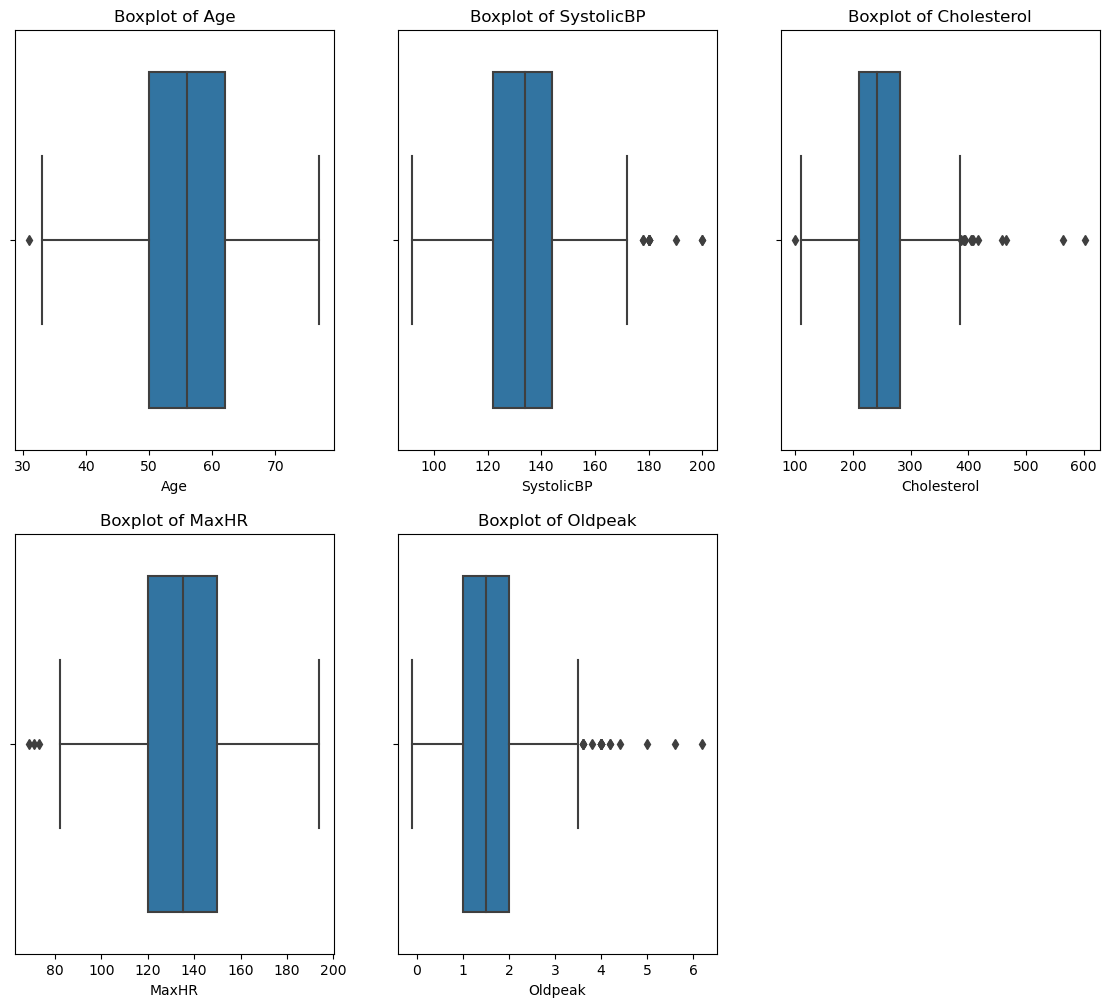

In [27]:
#Boxplot showing numerical variables

columns = cleaned_df.select_dtypes(include=['int64', 'float64']).columns

fig, axes = plt.subplots(2, 3, figsize=(14, 12))
axes = axes.flatten()  

for ax, col in zip(axes, columns):
    sns.boxplot(data=cleaned_df, x=col, ax=ax)
    ax.set_title(f'Boxplot of {col}')
    
for ax in range(len(columns), len(axes)):
    fig.delaxes(axes[ax])


We still have some outliers but they are valid values in clinical practice

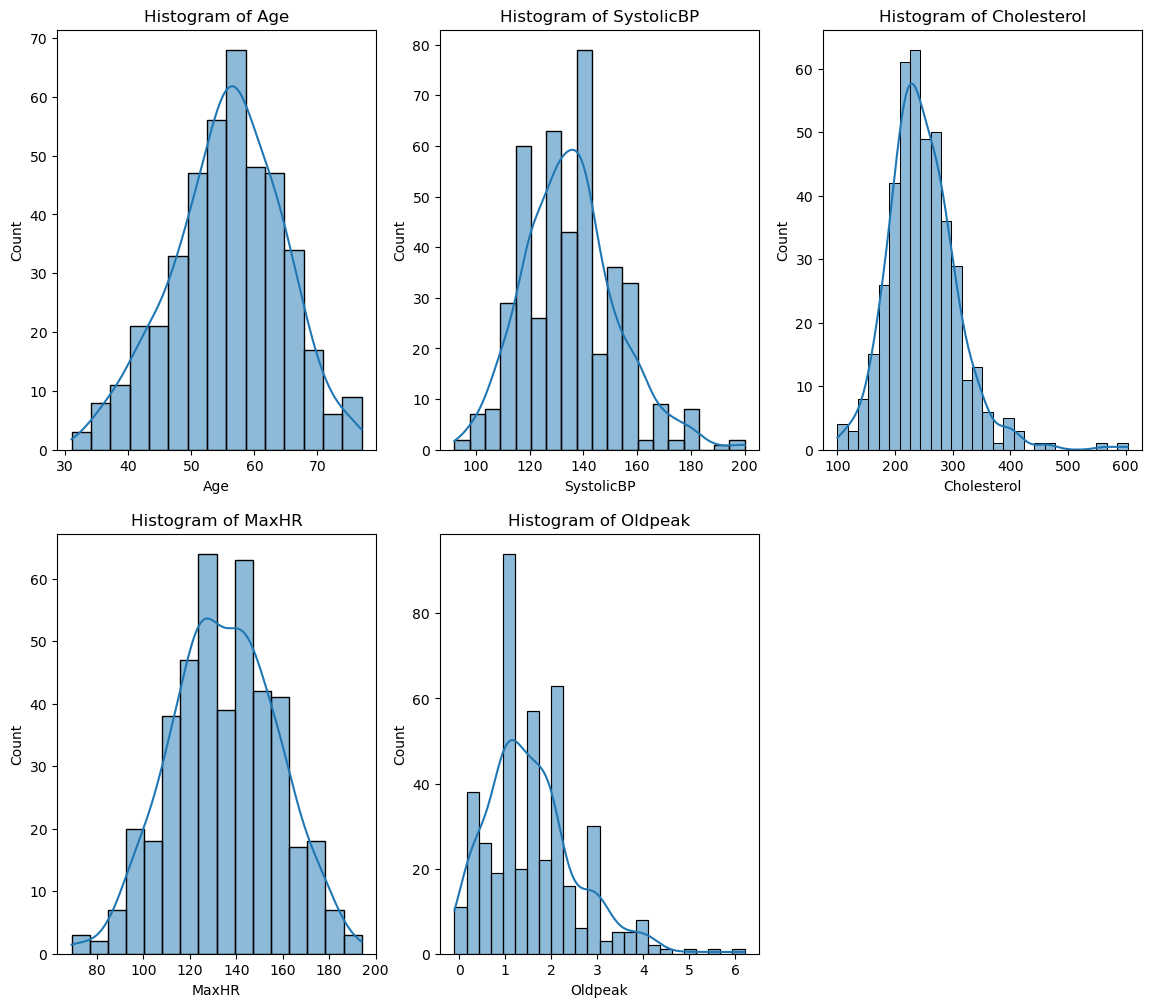

In [28]:
#Histogram showing numerical variables

columns = cleaned_df.select_dtypes(include=['int64', 'float64']).columns

fig, axes = plt.subplots(2, 3, figsize=(14, 12))
axes = axes.flatten() 

for ax, col in zip(axes, columns):
    sns.histplot(data=cleaned_df, x=col, kde = True, ax=ax)
    ax.set_title(f'Histogram of {col}')
    
for ax in range(len(columns), len(axes)):
    fig.delaxes(axes[ax])


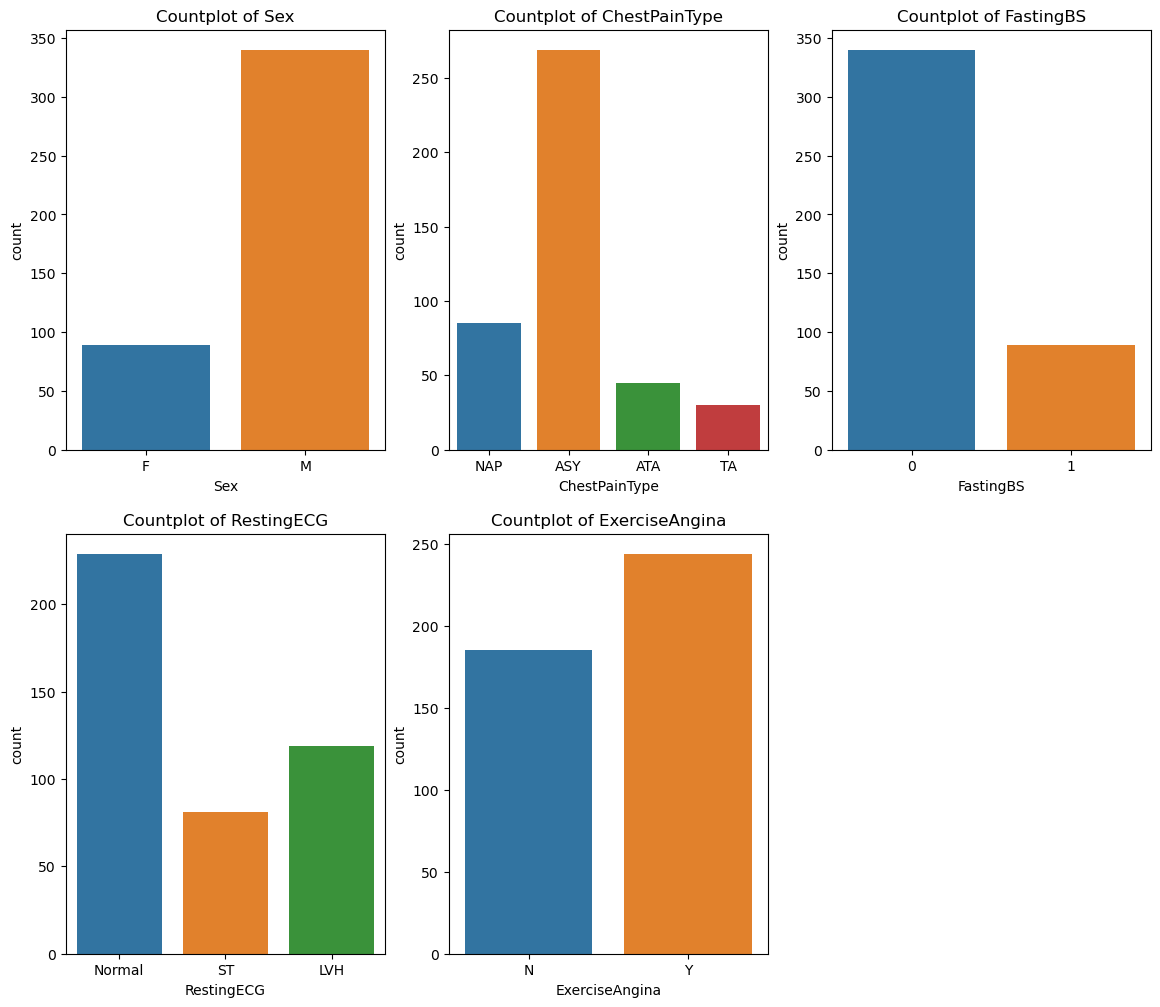

In [29]:
#countplot of categorical variables

cat_columns = cleaned_df.select_dtypes(include=['object', 'category']).columns

fig, axes = plt.subplots(2, 3, figsize=(14, 12))
axes = axes.flatten() 

for ax, col in zip(axes, cat_columns):
    sns.countplot(data=cleaned_df, x=col, ax=ax)
    ax.set_title(f'Countplot of {col}')
    
for ax in range(len(columns), len(axes)):
    fig.delaxes(axes[ax])

#### Data Preprocessing

In [30]:
#Dependent and independent variables
X = cleaned_df.drop(columns = ['HeartDisease'])
y = cleaned_df['HeartDisease']

In [31]:
#split dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42, stratify = y)

In [32]:
#Further processing our numerical and categorical columns
num_col_train = X_train.select_dtypes(include = ['int64', 'float64'])
cat_col_train = X_train.select_dtypes(include = ['object', 'category'])
num_col_test = X_test.select_dtypes(include = ['int64', 'float64'])
cat_col_test = X_test.select_dtypes(include = ['object', 'category'])

In [33]:
#scaler numerical variables
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(num_col_train)
X_test_scaled = scaler.transform(num_col_test)

In [34]:
#encode categorical variables
df_encoded = pd.get_dummies(X, columns=['Sex', 'ChestPainType', 'FastingBS', 'RestingECG', 'ExerciseAngina','ST_Slope'], drop_first=True)

In [35]:
# Final processing of the data for model training and evaluation
X_train_cat = df_encoded.loc[X_train.index, df_encoded.columns.difference(num_col_train.columns)]
X_test_cat = df_encoded.loc[X_test.index, df_encoded.columns.difference(num_col_train.columns)]
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=num_col_train.columns, index=num_col_train.index)
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=num_col_test.columns, index=num_col_test.index)
X_train_final = pd.concat([X_train_scaled_df, X_train_cat], axis=1)
X_test_final = pd.concat([X_test_scaled_df, X_test_cat], axis=1)

In [36]:
#Fit the model
log = LogisticRegression(max_iter=1000, random_state=42)
log.fit(X_train_final, y_train)

LogisticRegression(max_iter=1000, random_state=42)

#### Model Evaluation

In [37]:
#Predict with the model
y_test_pred = log.predict(X_test_final)
y_train_pred = log.predict(X_train_final)
y_test_pred_prob = log.predict_proba(X_test_final)[:,1]

In [38]:
#test accuracy
test_accuracy = accuracy_score(y_test, y_test_pred)
test_accuracy

0.8604651162790697

In [39]:
#train accuracy
train_accuracy = accuracy_score(y_train, y_train_pred)
train_accuracy

0.8513119533527697

In [40]:
accuracy_names = ['Test Accuracy', 'Train Accuracy']
accuracy_scores = [test_accuracy, train_accuracy]

train_test_accuracy = list(zip(accuracy_names, accuracy_scores))
df_train_test_accuracy = pd.DataFrame(train_test_accuracy, columns=['Type', 'Accuracy Score'])
print(df_train_test_accuracy)

             Type  Accuracy Score
0   Test Accuracy        0.860465
1  Train Accuracy        0.851312


Test and train accuracy shows no over or underfitting

In [41]:
#roc_auc score
roc_auc = roc_auc_score(y_test, y_test_pred_prob)
roc_auc

0.924404761904762

#### Cross validation and hyperparameter tuning

In [42]:
#cross validation of our model
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(log, X_train_final, y_train, 
                           cv=cv, scoring='accuracy')

print("Cross-Validation Scores:", cv_scores)
print(f"Mean CV Accuracy: {np.mean(cv_scores):.4f} (±{np.std(cv_scores):.4f})")


Cross-Validation Scores: [0.86956522 0.89855072 0.82608696 0.82352941 0.80882353]
Mean CV Accuracy: 0.8453 (±0.0335)


In [43]:
#lets carry out hyperparameter tuning to see if we can a model with better accuracy
param_grid = {
    'penalty': ['l1', 'l2'],  
    'C': np.logspace(-4, 4, 50), 
    'solver': ['liblinear', 'saga'],  
    'class_weight': [None, 'balanced']  
}

In [44]:
grid_search = GridSearchCV(estimator=log,
                          param_grid=param_grid,
                          cv=cv,
                          scoring= 'accuracy',
                          n_jobs=-1,  
                          verbose=1)  


In [45]:
grid_search.fit(X_train_final, y_train)

Fitting 5 folds for each of 400 candidates, totalling 2000 fits


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=LogisticRegression(max_iter=1000, random_state=42),
             n_jobs=-1,
             param_grid={'C': array([1.00000000e-04, 1.45634848e-04, 2.12095089e-04, 3.08884360e-04,
       4.49843267e-04, 6.55128557e-04, 9.54095476e-04, 1.38949549e-03,
       2.02358965e-03, 2.94705170e-03, 4.29193426e-03, 6.25055193e-03,
       9.10...
       1.67683294e+01, 2.44205309e+01, 3.55648031e+01, 5.17947468e+01,
       7.54312006e+01, 1.09854114e+02, 1.59985872e+02, 2.32995181e+02,
       3.39322177e+02, 4.94171336e+02, 7.19685673e+02, 1.04811313e+03,
       1.52641797e+03, 2.22299648e+03, 3.23745754e+03, 4.71486636e+03,
       6.86648845e+03, 1.00000000e+04]),
                         'class_weight': [None, 'balanced'],
                         'penalty': ['l1', 'l2'],
                         'solver': ['liblinear', 'saga']},
             scoring='accuracy', verbose=1)

In [46]:
print("Grid Search Best parameters found: ", grid_search.best_params_)
print("Grid Search Best accuracy score: ", grid_search.best_score_)

Grid Search Best parameters found:  {'C': 0.2682695795279725, 'class_weight': None, 'penalty': 'l2', 'solver': 'liblinear'}
Grid Search Best accuracy score:  0.8482949701619779


In [50]:
#a table showing models and their accuracy
model_names = ['Logistic Regression', 'Cross Validation', 'Grid Search']
accuracy_score = [test_accuracy, np.mean(cv_scores), grid_search.best_score_]

accuracy_table = list(zip(model_names, accuracy_score))
df_accuracy = pd.DataFrame(accuracy_table, columns=['Model', 'Accuracy'])
print(df_accuracy)

                 Model  Accuracy
0  Logistic Regression  0.860465
1     Cross Validation  0.845311
2          Grid Search  0.848295


Logistic Regression gives the best accuracy

#### Confusion matrix

In [51]:
confusion_matrix(y_test, y_test_pred)

array([[24,  6],
       [ 6, 50]], dtype=int64)

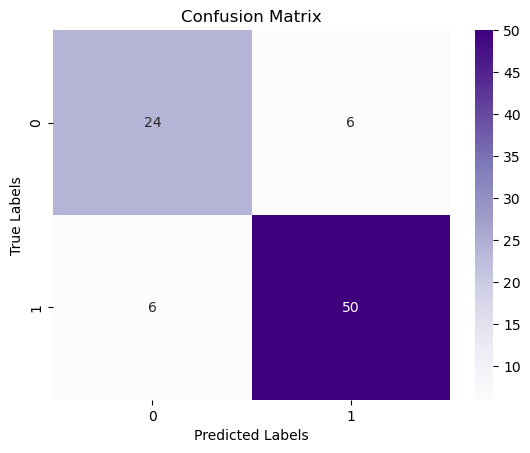

In [52]:
#plot confusion matrix
sns.heatmap(confusion_matrix(y_test, y_test_pred), annot = True, cmap = 'Purples')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

In [53]:
#plot ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_test_pred_prob)
roc_auc = auc(fpr, tpr)
roc_auc

0.924404761904762

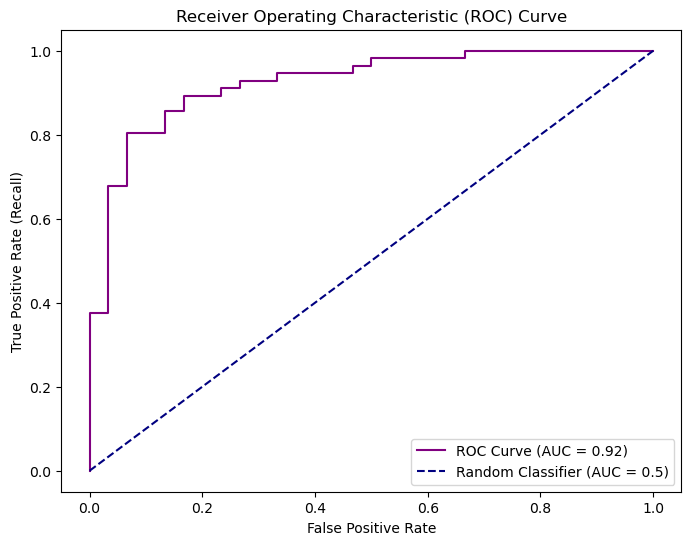

In [54]:
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc:.2f})", color='purple')
plt.plot([0, 1], [0, 1], linestyle='--', color='navy', label="Random Classifier (AUC = 0.5)")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate (Recall)")
plt.title("Receiver Operating Characteristic (ROC) Curve")
plt.legend(loc="lower right")
plt.show()


In [55]:
#precision recall curve 
precision, recall, thresholds = precision_recall_curve(y_test, y_test_pred_prob)
avg_precision = average_precision_score(y_test, y_test_pred_prob)

avg_precision

0.9572052386342621

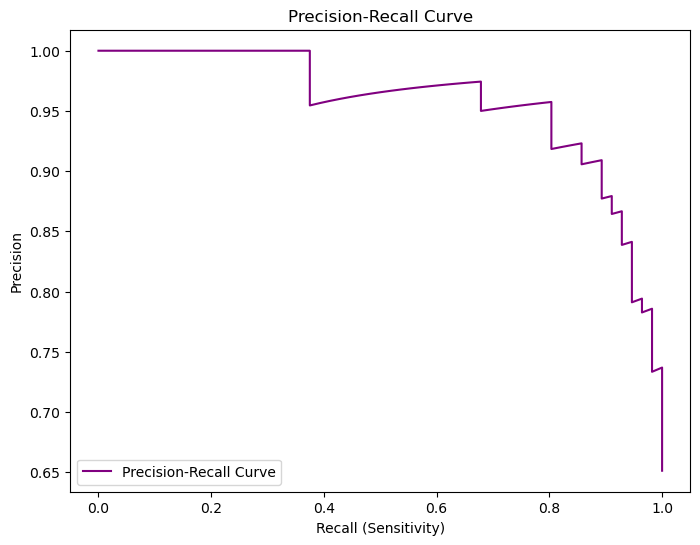

In [56]:
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color="purple", label= 'Precision-Recall Curve')
plt.xlabel("Recall (Sensitivity)")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend(loc="lower left")
plt.show()

#### Model Deployment

In [57]:
#save the model
joblib.dump(log, 'heart_disease_model.pki')

['heart_disease_model.pki']

## Conclusion

The heart disease prediction model has been successfully built and saved, achieving an accuracy of 86% and a ROC AUC score of 92%.